### Enunciado proyecto práctico

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, una solución óptima será alcanzada cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

   1) Implementar la red neuronal que se usará en la solución
    
   2) Implementar las distintas piezas de la solución DQN
    
   3) Justificar la respuesta en relación a los resultados obtenidos

IMPORTANTE:

- Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.

- Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).

- Tened en cuenta que las versiones de librerías recomendadas son Tensorflow==1.13.1, Keras==2.2.4 y keras-rl==0.4.2

### Instalar librerías

In [ ]:
!pip install gym

!pip install h5py==2.10.0

!pip install Pillow

!pip install gym[atari,accept-rom-license]

!pip install keras-rl==0.4.2

!pip install tensorflow==1.13.1

!pip install Keras==2.2.4

!pip install torch

#!pip install atari-py #Optional

#!pip install pyglet #Optional

In [2]:
!pip freeze | grep Keras

Keras==2.2.4
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2


In [3]:
!pip freeze | grep keras-rl

keras-rl==0.4.2


In [4]:
!pip freeze | grep tensorflow

tensorflow==1.13.1
tensorflow-datasets==4.0.1
tensorflow-estimator==1.13.0
tensorflow-gcs-config==2.7.0
tensorflow-hub==0.12.0
tensorflow-io-gcs-filesystem==0.22.0
tensorflow-metadata==1.4.0
tensorflow-probability==0.15.0


In [ ]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, MaxPooling2D
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

import matplotlib.pyplot as plt
import json

### Configuración base

#### Descarga Atari ROMS

In [6]:
# habilitar la primera vez
! wget http://www.atarimania.com/roms/Roms.rar

--2021-12-17 17:53:31--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   647KB/s    in 17s     

2021-12-17 17:53:49 (624 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



In [7]:
! mkdir /content/ROM/

In [8]:
! unrar e /content/Roms.rar /content/ROM/


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK


In [ ]:
! python -m atari_py.import_roms /content/ROM/

### Experimento #1

#### Configuración del entorno

In [13]:
#INPUT_SHAPE = (80, 80)
INPUT_WIDTH = 84#105
INPUT_HEIGHT = 84

WINDOW_LENGTH = 4

In [53]:
# In this example, we need to preprocess the observations
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        #print(observation.shape)
        img = Image.fromarray(observation)
        img = img.resize((INPUT_HEIGHT,INPUT_WIDTH)).convert('L')
        processed_observation = np.array(img)
        #img.save("/content/observation.png")
        #print(processed_observation.shape)
        assert processed_observation.shape == (INPUT_WIDTH,INPUT_HEIGHT)
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [54]:
# Get the environment and extract the number of actions.
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
print(f"Cantidad de acciones: {nb_actions}")
print(f"Espacio de observaciones: {env.observation_space}")

Cantidad de acciones: 6
Espacio de observaciones: Box(0, 255, (210, 160, 3), uint8)


#### Implementación de la red neuronal

In [55]:
# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + (INPUT_WIDTH,INPUT_HEIGHT)
model=0
model = Sequential()

if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')

model.add(Convolution2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))

model.add(Convolution2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(nb_actions))
model.add(Activation('linear'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_11 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_12 (Activation)   (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_13 (Activation)   (None, 7, 7, 64)          0         
__________

#### Implementación de la solución DQN

In [56]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

In [57]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.1, value_test=0.05, nb_steps=25000)

In [63]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=1500, gamma=.99,
               target_model_update=200, train_interval=20) 

dqn.compile(Adam(lr=.00025), metrics=['mae'])

#### Entrenamiento

In [42]:
# Training part
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=2000)]
callbacks += [FileLogger(log_filename, interval=100)]

dqn.fit(env, callbacks=callbacks, nb_steps=50000, log_interval=2000, visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

Training for 50000 steps ...
Interval 1 (0 steps performed)
2000/2000 [==============================] - 16s 8ms/step - reward: 0.0170
2 episodes - episode_reward: 11.000 [6.000, 16.000] - loss: 0.010 - mean_absolute_error: 0.471 - mean_q: 0.583 - mean_eps: 0.937 - ale.lives: 2.184

Interval 2 (2000 steps performed)
2000/2000 [==============================] - 23s 11ms/step - reward: 0.0175
3 episodes - episode_reward: 14.333 [12.000, 17.000] - loss: 0.011 - mean_absolute_error: 0.650 - mean_q: 0.807 - mean_eps: 0.892 - ale.lives: 2.319

Interval 3 (4000 steps performed)
2000/2000 [==============================] - 24s 12ms/step - reward: 0.0155
3 episodes - episode_reward: 11.333 [9.000, 15.000] - loss: 0.009 - mean_absolute_error: 0.930 - mean_q: 1.143 - mean_eps: 0.820 - ale.lives: 2.091

Interval 4 (6000 steps performed)
2000/2000 [==============================] - 23s 12ms/step - reward: 0.0190
2 episodes - episode_reward: 6.000 [4.000, 8.000] - loss: 0.012 - mean_absolute_error: 

#### Gráfica de entrenamiento

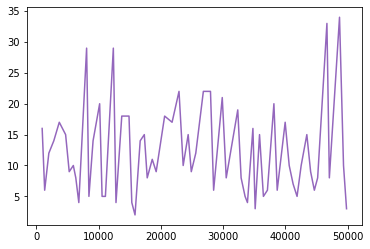

In [43]:
dictionary = json.load(open(log_filename, 'r'))
fig, ax = plt.subplots()
ax.plot(dictionary['nb_steps'], dictionary['episode_reward'], color = 'tab:purple')
plt.show()

#### Test

In [66]:
# Testing part to calculate the mean reward
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
dqn.load_weights(weights_filename)
history_dict = dqn.test(env, nb_episodes=10, visualize=False).history
test_reward_average = np.mean(history_dict['episode_reward'])
print(f"Episodes reward average: {test_reward_average}")

Testing for 10 episodes ...
Episode 1: reward: 17.000, steps: 781
Episode 2: reward: 20.000, steps: 980
Episode 3: reward: 24.000, steps: 1088
Episode 4: reward: 29.000, steps: 1479
Episode 5: reward: 18.000, steps: 798
Episode 6: reward: 10.000, steps: 599
Episode 7: reward: 28.000, steps: 1309
Episode 8: reward: 19.000, steps: 1094
Episode 9: reward: 26.000, steps: 1108
Episode 10: reward: 20.000, steps: 1192
Episodes reward average: 21.1


#### Parámetros seleccionados y conclusiones

Con el objetivo de lograr objetivo del proyecto (20 puntos de recompensa en promedio), dividimos el esfuerzo de optimizar el algoritmo en tres frentes:

**Procesamiento de las observaciones y red neuronal**

En este primer experimento buscamos optimizar el algoritmo utilizando la misma configuración de red neuronal vista en el ejercicio de Breakout con el parámetro WINDOW_LENGTH en 4 (4 imagenes por estado) y resolución de 84x84.

**Optimización de la policy ajustando los hiperparámetros del épsilon**

Los mejores resultados se obtuvieron aplicando una redución del epsilon desde 1 hasta 0.1 en un rango de 25.000 steps. Se realizaron pruebas con epsilon de 1 a 0.5 para mantener una exploración/explotación equilibrada pero sin lograr mejora en el entrenamiento.

**Optimización de hiperparámetros del agente DQN**

Para el agente DQN estamos actualizando el target model 200 steps, parámetro con el cual logramos mejores episodios de entrenamiento. 

**Resultados en modo test**

Visualizando el agente en modo test, encontramos que en este experimento el agente encontró una estrategia de moverse rapidamente de izquierda a derecha todo el tiempo logrando evitar los ataques del enemigo y maximizando la recompensa.

Cabe anotar que la prueba de ejecutó cargando los mejores pesos encontrados durante las diferentes ejecuciones.

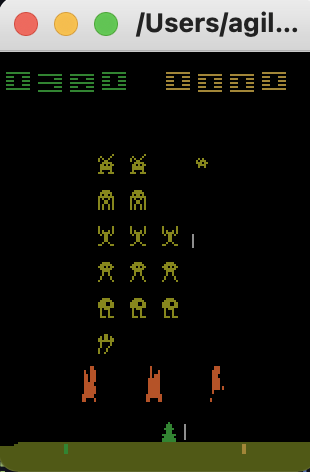


### Experimento #2

#### Configuración del entorno

In [67]:
#INPUT_SHAPE = (80, 80)
INPUT_WIDTH = 80#105
INPUT_HEIGHT = 80

WINDOW_LENGTH = 8

In [68]:
# In this example, we need to preprocess the observations
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        #print(observation.shape)
        img = Image.fromarray(observation)
        img = img.resize((INPUT_HEIGHT,INPUT_WIDTH)).convert('L')
        processed_observation = np.array(img)
        #img.save("/content/observation.png")
        #print(processed_observation.shape)
        assert processed_observation.shape == (INPUT_WIDTH,INPUT_HEIGHT)
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [69]:
# Get the environment and extract the number of actions.
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
print(f"Cantidad de acciones: {nb_actions}")
print(f"Espacio de observaciones: {env.observation_space}")

Cantidad de acciones: 6
Espacio de observaciones: Box(0, 255, (210, 160, 3), uint8)


#### Implementación de la red neuronal

In [70]:
# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + (INPUT_WIDTH,INPUT_HEIGHT)
model=0
model = Sequential()

if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')

model.add(Convolution2D(32, (3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(128, (3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_actions))
model.add(Activation('linear'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_4 (Permute)          (None, 80, 80, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 80, 32)        2336      
_________________________________________________________________
activation_16 (Activation)   (None, 80, 80, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
activation_17 (Activation)   (None, 40, 40, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
__________

#### Implementación de la solución DQN

In [80]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()

In [81]:
load_trained_weigths = True
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.1, value_test=0.05, nb_steps=25000)

if load_trained_weigths:
  policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.5, value_min=0.1, value_test=0.05, nb_steps=25000)

In [82]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=1500, gamma=.99,
               target_model_update=200, train_interval=20) 

dqn.compile(Adam(lr=.00025), metrics=['mae'])

#### Entrenamiento

In [74]:
# Training part
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=2000)]
callbacks += [FileLogger(log_filename, interval=100)]

if load_trained_weigths:
  dqn.load_weights(weights_filename)

dqn.fit(env, callbacks=callbacks, nb_steps=50000, log_interval=2000, visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

Training for 50000 steps ...
Interval 1 (0 steps performed)
2000/2000 [==============================] - 40s 20ms/step - reward: 0.0200
3 episodes - episode_reward: 11.667 [8.000, 15.000] - loss: 0.018 - mean_absolute_error: 1.057 - mean_q: 1.304 - mean_eps: 0.472 - ale.lives: 2.242

Interval 2 (2000 steps performed)
2000/2000 [==============================] - 84s 42ms/step - reward: 0.0130
3 episodes - episode_reward: 8.667 [4.000, 11.000] - loss: 0.013 - mean_absolute_error: 1.176 - mean_q: 1.448 - mean_eps: 0.452 - ale.lives: 1.754

Interval 3 (4000 steps performed)
2000/2000 [==============================] - 84s 42ms/step - reward: 0.0155
3 episodes - episode_reward: 12.000 [8.000, 16.000] - loss: 0.012 - mean_absolute_error: 1.172 - mean_q: 1.441 - mean_eps: 0.420 - ale.lives: 1.692

Interval 4 (6000 steps performed)
2000/2000 [==============================] - 84s 42ms/step - reward: 0.0175
3 episodes - episode_reward: 9.000 [6.000, 12.000] - loss: 0.009 - mean_absolute_error: 

#### Gráfica de entrenamiento

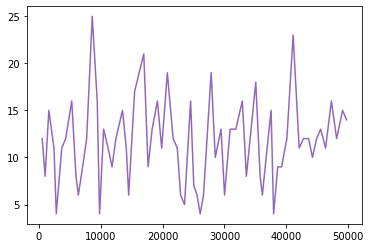

In [75]:
dictionary = json.load(open(log_filename, 'r'))
fig, ax = plt.subplots()
ax.plot(dictionary['nb_steps'], dictionary['episode_reward'], color = 'tab:purple')
plt.show()

#### Test

In [83]:
# Testing part to calculate the mean reward
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
dqn.load_weights(weights_filename)
history_dict = dqn.test(env, nb_episodes=10, visualize=False).history
test_reward_average = np.mean(history_dict['episode_reward'])
print(f"Episodes reward average: {test_reward_average}")

Testing for 10 episodes ...
Episode 1: reward: 22.000, steps: 1017
Episode 2: reward: 19.000, steps: 1043
Episode 3: reward: 20.000, steps: 1037
Episode 4: reward: 21.000, steps: 1037
Episode 5: reward: 24.000, steps: 1134
Episode 6: reward: 20.000, steps: 1050
Episode 7: reward: 20.000, steps: 1044
Episode 8: reward: 20.000, steps: 1022
Episode 9: reward: 20.000, steps: 1039
Episode 10: reward: 23.000, steps: 1142
Episodes reward average: 20.9


#### Parámetros seleccionados y conclusiones

En este experimento buscamos aplicar la estrategia de re-entrenar a partir de un archivo de pesos optimo encontrado en ejecuciones previas.

**Procesamiento de las observaciones y red neuronal**

En este caso realizamos pruebas ajustando el parámetro WINDOW_LENGTH primero con una sola imagen y aumentando de 1 en 1 hasta llegar a 8 donde obtuvimos los mejores resultados con una arquitectura de red neuronal que utiliza max pooling a la salida de cada capa convolucional, filtros 3x3, stride de 1 y padding 'same'. Un punto no tan favorable es que al tener mas imagenes por estado y mayor cantidad de parámetros en la red, el entrenamiento se hizo algo lento.

Tambien experimentamos con diferentes resoluciones y relaciones de aspecto de las imagenes encontrando mejores resultados con la resolución 80x80

**Optimización de la policy ajustando los hiperparámetros del épsilon**

Misma épsilon policy aplicada en el experimento #1

**Optimización de hiperparámetros del agente DQN**

Mismos parámetros aplicados al experimeinto #1

**Resultados en modo Test**

Al visualizar el algoritmo en modo test, encontramos que el agente aprendió una estrategía de moverse inmediatamente a la derecha de la pantalla hasta el final y quedarse allí maximizando la recompensa.

Lo especial de los resultados en este experimento es la estabilidad de la recompensa obtenida en cada uno de los episodios.

Cabe anotar que la prueba de ejecutó cargando los mejores pesos encontrados durante las diferentes ejecuciones.

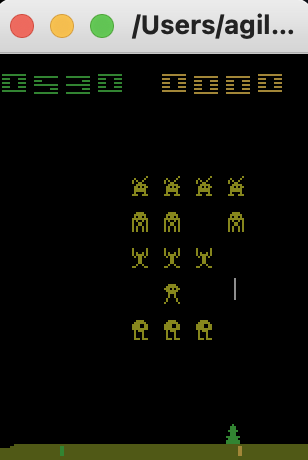